# Decompose and reconstruct cortical maps

In this tutorial we will use the geometric eigenmodes as a basis set to decompose and reconstruct a 
cortical map $y(\vec r)$ via the relation

$$
\displaystyle y(\vec r)=\sum_{j=1}^N \beta_j \psi_j (\vec r),
$$

where:
- $\psi_j (\vec r)$ denotes the $j^{th}$ mode
- $\beta_j$ denotes the weighting (or contribution) of the $j^{th}$ mode
- $N$ denotes the number of modes used for decomposition / reconstruction

As in the previous tutorial, we begin by initialising the EigenSolver with a cortical surface and 
medial wall mask. For convenience, we can also solve for the eigenmodes in the same line:

In [ ]:
from importlib.resources import files, as_file
import matplotlib.pyplot as plt
from nsbutils.plotting import plot_surf
from nsbutils.utils import unmask
import numpy as np
from neuromodes import EigenSolver
from neuromodes.basis import calc_norm_power
from neuromodes.io import fetch_surf, fetch_map

# Load surface and initialise solver
mesh, medmask = fetch_surf()
solver = EigenSolver(mesh, mask=medmask).solve(200)

For the map of interest, we can grab the principal gradient of functional connectivity first described 
by [Margulies *et al.* (2016)](https://doi.org/10.1073/pnas.1608282113), apply the medial wall mask,
then obtain $\beta$ weights by calling the `decompose` class method:

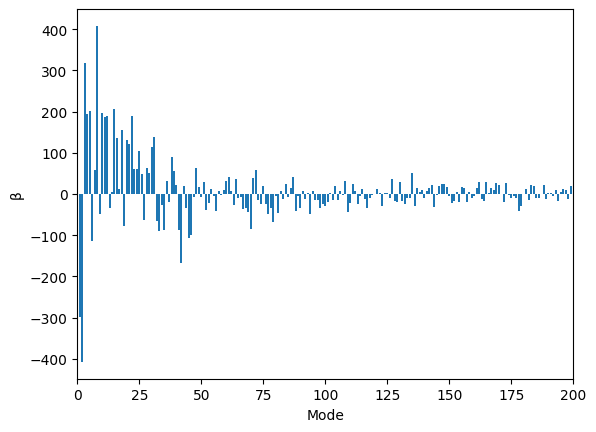

In [2]:
map = fetch_map('fcgradient1')
masked_map = map[medmask]

beta = solver.decompose(masked_map)

# Plot beta weights
plt.bar(range(beta.shape[0]), beta[:, 0])
plt.xlabel('Mode')
plt.xlim(0, solver.n_modes)
plt.ylabel('β')
plt.show()

Since eigenmodes represent standing wave patterns, their signs, and thus the signs of $\beta$ 
coefficients, are arbitrary. We can equivalently plot the normalised power 
($|\beta|^2/\Sigma|\beta|^2$) to more clearly display the dominance of lower modes:

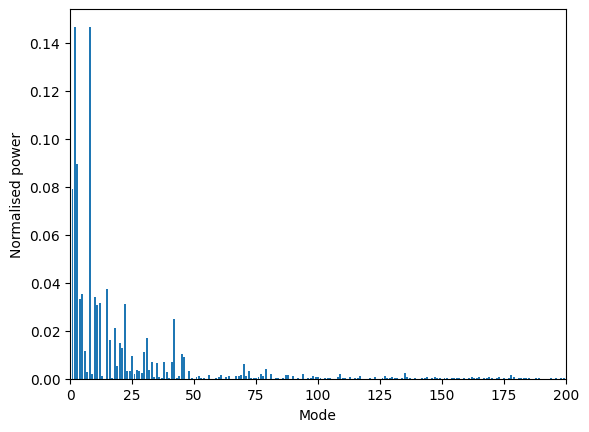

In [3]:
norm_power = calc_norm_power(beta)

plt.bar(range(norm_power.shape[0]), norm_power[:, 0])
plt.xlabel('Mode')
plt.xlim(0, solver.n_modes)
plt.ylabel('Normalised power')
plt.show()

We can reconstruct our map of interest using the first 1-200 modes by calling the `reconstruct` 
class method, which will decompose and reconstruct the map, then find the error associated with each reconstruction:

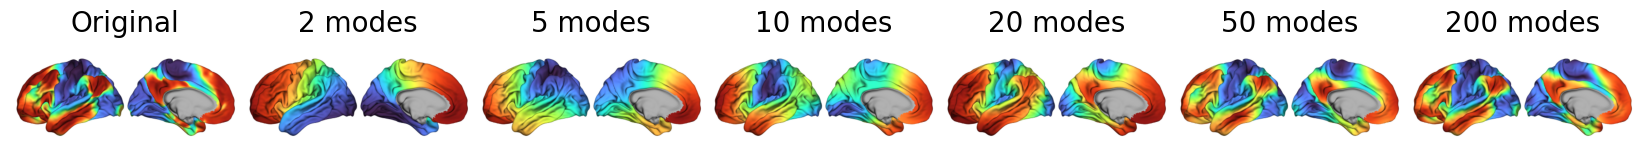

In [4]:
recon, err, beta = solver.reconstruct(masked_map)

# Plot reconstructions next to original map
n_modes_to_plot = [2, 5, 10, 20, 50, 200]
lh_surfpath = files('neuromodes.data') / 'sp-human_tpl-fsLR_den-32k_hemi-L_midthickness.surf.gii'

data = unmask(masked_map, medmask)[:, np.newaxis]  # Original map
for n_modes in n_modes_to_plot:
    recon_map = unmask(recon[:, n_modes - 1, 0], medmask)[:, np.newaxis]
    data = np.concatenate((data, recon_map), axis=1)

with as_file(lh_surfpath) as lh_surfpath:
    plot_surf(lh_surfpath, data, labels=['Original'] + [f'{n} modes' for n in n_modes_to_plot])


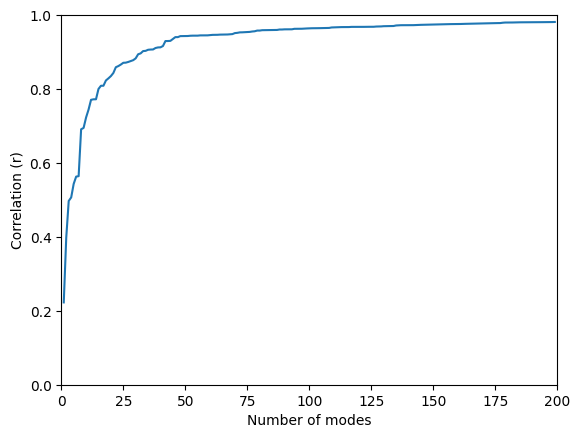

In [5]:
# Plot reconstruction accuracy
plt.plot(1-err[:, 0]) # reports the error (1 - corr) by default
plt.xlabel('Number of modes')
plt.ylabel('Correlation (r)')
plt.xlim(0, solver.n_modes)
plt.ylim(0, 1)
plt.show()